# Tittle: Identification of Marker Genes in Human Breast Tumors using scRNA 
# Introduction

Tamoxifen is a selective estrogen receptor modulator (SERM) medication used to treat breast cancer. breast cancer is a major type of cancer in females. Detecting cancer early poses a significant challenge due to its inherent heterogeneity. In ER-positive, HER2-negative breast cancer, multiple measures of intra-tumor heterogeneity are associated with worse response to endocrine therapy

Recent progress in next-generation technologies has facilitated the exploration of novel gene expressions involved in breast cancer pathogenesis. The utilization of Next-Generation Sequencing (NGS) methods has generated extensive datasets, necessitating computationally intensive analyses. Consequently, machine learning models have been deployed to effectively analyze these large datasets. Machine learning algorithms have demonstrated their effectiveness and computational efficiency in identifying disease biomarkers from high-dimensional datasets.

In this project, we leverage a single-cell-RNA dataset combined with machine learning techniques to identify and determine breast cancer biomarkers. To identify gene signatures associated with breast cancer for six different types of breast cancer tumors, we will use Scanpy.


# Research Questions
1. Which genes are differentially expressed in breat cancer?
2. Which genes are co-expressed in breast cancer?
3. What is the expression pattern of differentially expressed genes?

# Dataset

The dataset under consideration comprises samples from the population of live human tumors and normal breast specimens tha were taken immediately after surgical resection for processing into single-cell workflows for experimentation and genomic analyses.I this study, we show differences in tamoxifen response by cell type. The data set was obtained from NCBI GEO database under the accession number GSE245601

# Methodology
- Data Acqusition: h5 format
- Preprocessing and Quality control: Gene, cell and mitochondria filtering
- Clustering: UMAP
- Data Visualization: Dot plots,violin, track plots,scatter plots, heatmaps
- Benchmarking: Literature Search

In [94]:
# ignore warnings and standasrd outputs
import warnings
from contextlib import redirect_stdout
import io

warnings.filterwarnings("ignore")

stdout_buffer = io.StringIO()

with redirect_stdout(stdout_buffer):
    # Your code here
    print("This won't be printed")

output = stdout_buffer.getvalue()


# Workflow

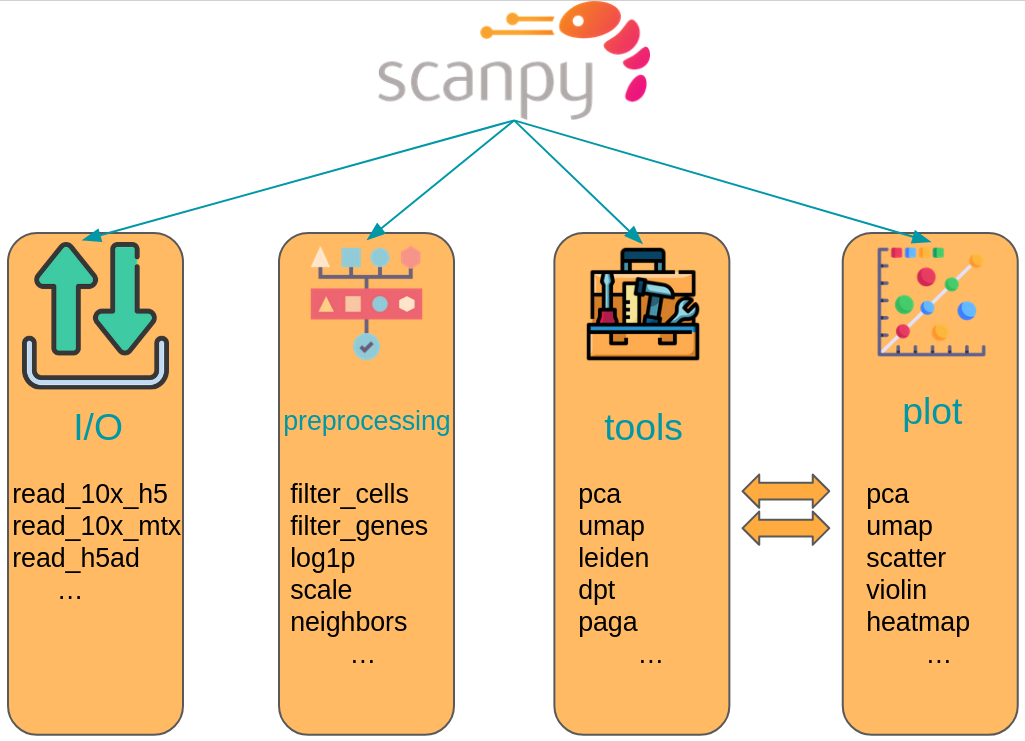

In [95]:
from IPython.display import Image, display

# Replace 'path_to_your_image.jpg' with the actual path to your image file
image_path = 'scanpy_set_up.png'

# Display the image
display(Image(filename=image_path))


*Workflow Figure was adapted from https://www.sc-best-practices.org/introduction/analysis_tools.html*

# Data Acquisition
The datset was downloaded using ftp commandline as follows
Counts data

!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE118nnn/GSE118389/suppl/GSE118389%5Fnorm%5Fdata%2Etxt%2Egz

The counts data represent the number of RNA sequencing reads that have been aligned to each gene in the transcriptome. These counts can be indicative of the level of gene expression in the samples. The file contains gene expression data in the form of counts, derived from RNA sequencing experiments

Normalized counts data
! wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE118nnn/GSE118389/suppl/GSE118389%5Fnorm%5Fdata%2Etxt%2Egz

This file likely contains normalized gene expression data from the same RNA sequencing experiments.
Normalization is a process used to adjust for technical variations between samples, allowing for more accurate comparisons of gene expression levels across different experimental conditions or samples.


# Scanpy set up and loading required libraries

In [96]:
import pandas as pd
import scanpy as sc
import os
import numpy as np
import scipy
import scipy.io as sio
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)# supress some warnings
sc.settings.verbosity = 3


# Data integration
The data was in multiple .h5 files. We used a function to merge the different files into a single file

In [97]:
import h5py
import os
output_file = "output.h5"
folder_path = "../data/"

output_file = "../data/output.h5"

# Get a list of H5 files in the folder
d_names = [f for f in os.listdir(folder_path) if f.endswith('Control.h5')]

# Dictionary to store the database structure
d_struct = {}

# Iterate over H5 files and get group names
for i in d_names:
    path = os.path.join(folder_path, i)
    # print(path)

    with h5py.File(path, 'r') as f:
        d_struct[i] = list(f.keys())

# Create the output H5 file
with h5py.File(output_file, 'w') as outfile:
    # Iterate over H5 files and copy datasets to the output file
    for i in d_names:
        path = os.path.join(folder_path, i)
        with h5py.File(path, 'r') as f:
            for j in d_struct[i]:
                # Check if the dataset already exists in the output file
                if j in outfile:
                    continue
                    # print(f"Dataset '{j}' already exists in the output file. Skipping.")
                else:
                    # Copy dataset from the original file to the output file
                    f.copy(j, outfile, name=j)

# print("Datasets copied successfully.")

In [98]:
#Load data
data= sc.read_10x_h5("../data/output.h5")

reading ../data/output.h5
 (0:00:01)


# Data Wrangling/ Exploratory Data Analysis
In this section, we will answer below questions
- How many genes are in the raw count dataset?
- How many cells?
- Are there mitochondria contaminants?
- Which genes are highly expressed?


Number of cells (observations or n_obs): 4267

Number of genes (variables or n_vars): 33538

In [99]:
# data
#check total number of mitochondrial genes in the dataset
data.var_names.str.contains("MT-").sum()

14

In [100]:
 # annotate the group of mitochondrial genes as 'MT'
data.var['MT'] = data.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(data, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [101]:
# check the genes and count statistics 
data.var

gene_ids    feature_types  genome     MT  \
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False   
FAM138A      ENSG00000237613  Gene Expression  GRCh38  False   
OR4F5        ENSG00000186092  Gene Expression  GRCh38  False   
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  False   
AL627309.3   ENSG00000239945  Gene Expression  GRCh38  False   
...                      ...              ...     ...    ...   
AC233755.2   ENSG00000277856  Gene Expression  GRCh38  False   
AC233755.1   ENSG00000275063  Gene Expression  GRCh38  False   
AC240274.1   ENSG00000271254  Gene Expression  GRCh38  False   
AC213203.1   ENSG00000277475  Gene Expression  GRCh38  False   
FAM231C      ENSG00000268674  Gene Expression  GRCh38  False   

             n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
MIR1302-2HG                  0     0.000000             100.000000   
FAM138A                      0     0.000000             100.000000   
OR4F5                        0     0.000000             100.000000   
AL627309.1                  14     0.003281              99.671901   
AL627309.3                   2     0.000469              99.953129   
...                        ...          ...                    ...   
AC233755.2                   0     0.000000             100.000000   
AC233755.1                   0     0.000000             100.000000   
AC240274.1                 228     0.067260              94.656667   
AC213203.1                   0     0.000000             100.000000   
FAM231C                      0     0.000000             100.000000   

             total_counts  
MIR1302-2HG           0.0  
FAM138A               0.0  
OR4F5                 0.0  
AL627309.1           14.0  
AL627309.3            2.0  
...                   ...  
AC233755.2            0.0  
AC233755.1            0.0  
AC240274.1          287.0  
AC213203.1            0.0  
FAM231C               0.0  

[33538 rows x 8 columns]

In [102]:
#make the gene names unique
data.var_names_make_unique()

# Quality Control and Filtering
- Mitochondrial gene composition.
Mitochondrial genes often start with "MT-" or "MTRNR," and their inclusion helps estimate the mitochondrial composition of each cell. Most of the cells have a mitochondria count percentage below 15%. The cells with higher than 15% mitochondria count may signify cell stress and damage and were therefore filterd out.
- Cell counts. Cells with less than 500 genes were excluded from downstream analysis. The low gene count in cells can be due to low capture, inefficient cell lysis or non-viable cells.
Each violin plot represents the distribution of the number of genes expressed per cell.
- Gene counts
- Cells with less than 20000 total count were excluded from the analysis.


## Violin Plot

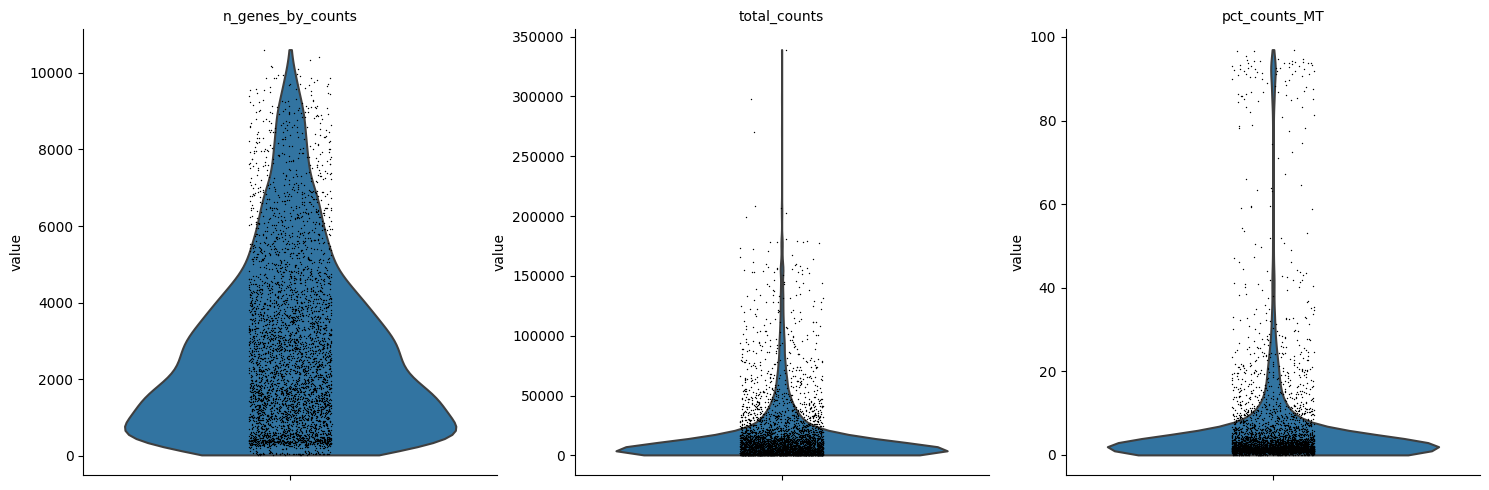

In [103]:
sc.pl.violin(
    data, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_MT'
     ],
    multi_panel=True,
    # save='_gene_MT_vs_transcript_counts',
);

## Scatter Plots

The plots indicate that some reads have a relatively high percentage of mitochondrial counts which are often associated with cell degradation. However, most of the cells have less than 15% mitochondria percentage which. We can also observe most cells have total counts of below 20000. For gene counts per cell, most cells approximately contain about 5000 gene counts on average. These visualizations were used to set the quality control thresholds. We also filter out genes that are not detected in at least 20 cells as these are not informative.

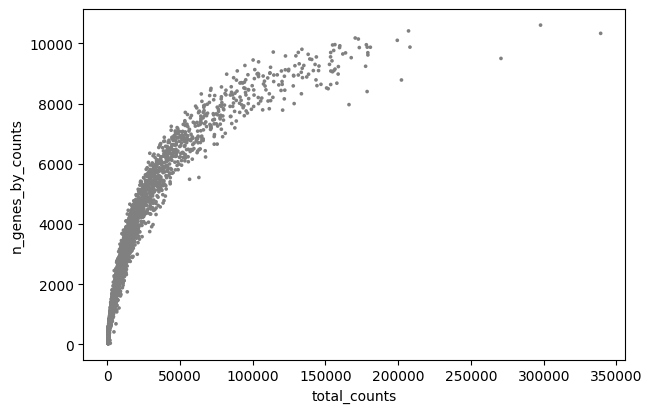

In [104]:
sc.pl.scatter(data, "total_counts", "n_genes_by_counts")

The scatter plot shows gene counts per each gene. The output shows presence of potential outliers for gene counts

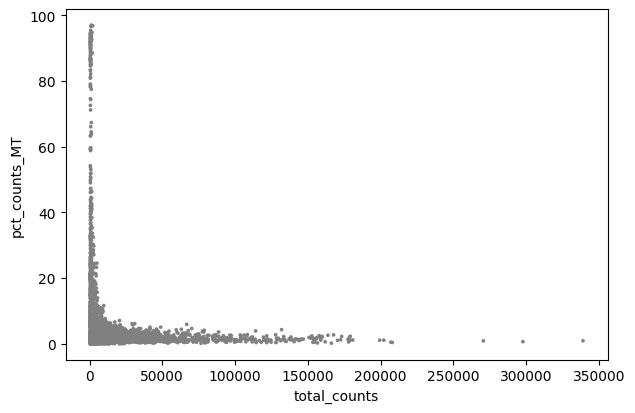

In [105]:
sc.pl.scatter(data, "total_counts", "pct_counts_MT")

From the scatter plot, few cells have mitochondria composition above 15% which is the desirable threshold. We will filter cells with a percentage count above 15% mitochondria count

In [106]:
# Filter the data
data = data[data.obs.n_genes_by_counts < 5000,:]
data = data[data.obs.total_counts < 20000,:]
data = data[data.obs.pct_counts_MT < 15,:]
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(data, min_cells=20)
data.shape # Checking number of cells remaining

filtered out 19290 genes that are detected in less than 20 cells


(2972, 14248)

We have filtered cells with less than 500 genes, cells with less than 20000 total count and cells with more than 15% mitochondrial gene composition and genes that are only present in 20 cells or less.

## Violin plots after QC

After filtering, the number of genes remaining is 2972 and the number of cells remainaing is 33538

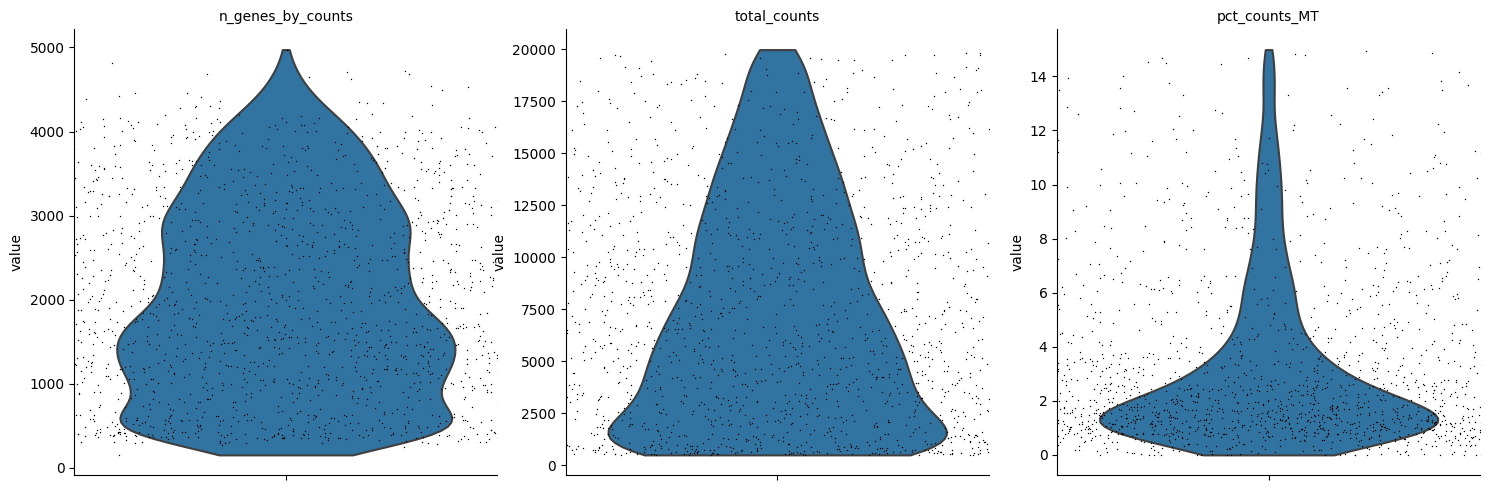

In [107]:
sc.pl.violin(
    data, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_MT'
     ],
    jitter=1,
    multi_panel=True,
    # save='Filtered_gene_MT_vs_transcript_counts'
   
)


After the quality control, we can see the interquartile ranges for gene counts, total counts and mitochondria composition are within the expected ranges based on the previous filtered parameters. 

## Scatter plot after QC

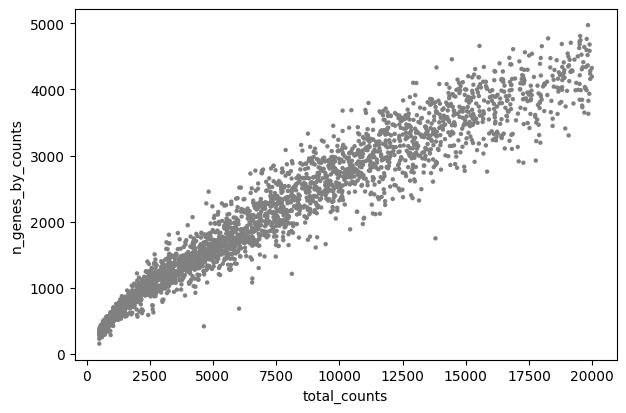

In [108]:
sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts')

The scatter plot shows the distribution of the number of gene counts. We can see the gene counts increase with the increase in total counts for the genes. The plot also shows the presence of potential outliers in some gene counts. Before filtering, we can normalize the counts and visualize nwe the distribution.

# Normalization
This step is performed to account for technical biases and variability across cells, ensuring that the observed differences in gene expression are reflective of biological signals rather than technical artifacts. For example
- Each cell in a scRNA-seq experiment may have a different number of RNA molecules, resulting in variability in library sizes
-  samples are processed at different times, and batch effects can introduce unwanted variability.
-   Longer genes generally produce more sequencing reads, and some cells may be sequenced more deeply than others.
-   Technical variations such as amplification bias, and sequencing biases
  
In this project, transcripts per million (TPm) normalization and log normalization have been used. The log normalization was adopted since scRNA has high variance.

In [109]:
#normarization
data.layers["counts"] = data.X.copy() # preserve counts
sc.pp.normalize_total(data, target_sum=1e6) # scale each cell to a common library size
sc.pp.log1p(data) # log(expression + 1)
data.raw = data # freeze the state in `.raw`

normalizing counts per cell
    finished (0:00:00)


## Gene counts after QC and Normalization

In [110]:
print("min_gene count is ", data.obs["n_genes_by_counts"].min(), "\n max_gene count is ",data.obs["n_genes_by_counts"].max())

min_gene count is  155 
 max_gene count is  4974


In [111]:
data.obs["n_genes_by_counts"].max()

4974

# Highly variable genes
Discarding non-significant genes that are equally expressed across the cells is a preprocessing step in scRNA-seq analysis. This process is performed to reduce noise, to focus on the most informative genes, and improve the efficiency of downstream analyses. After extracting highly variable genes, we see that only 6684 genes remained for downstream analysis.

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


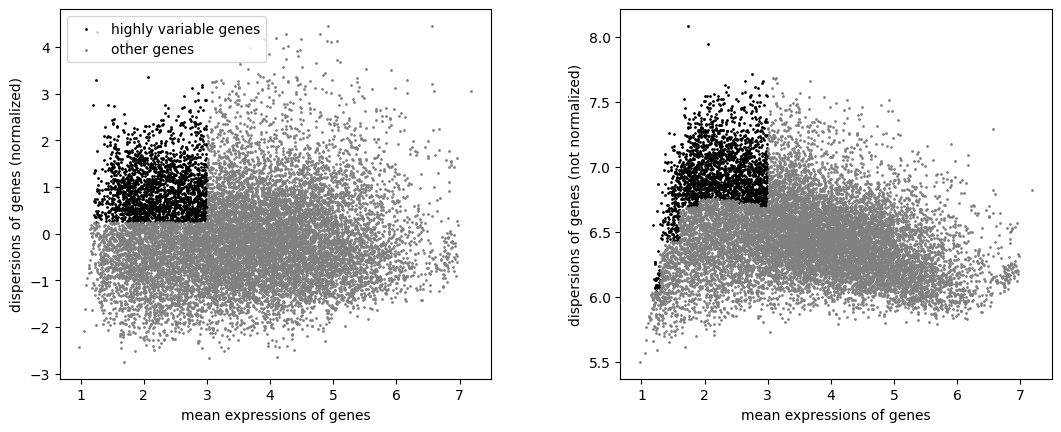

In [81]:
#determining High variable genes
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.25)
sc.pl.highly_variable_genes(data) 

The plots show that before normalization, the dispersion of genes have wide range from 3.2 to 3.9. Aftwr bnormalization, there is positive and negative dispersion ranging from -2 to 2. Genes with a mean expression below 0.25 dispersion  threshold were excluded from consideration as highly variable genes

In [82]:
data.raw=data
data = data[:, data.var['highly_variable']]
sc.pp.scale(data, zero_center=True, max_value=3)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [83]:
print("min_nom",data.var["dispersions_norm"].min(),"\nmax_norm is",data.var["dispersions_norm"].max())

min_nom 0.25000563 
max_norm is 4.3261504


normalizing counts per cell
    finished (0:00:00)


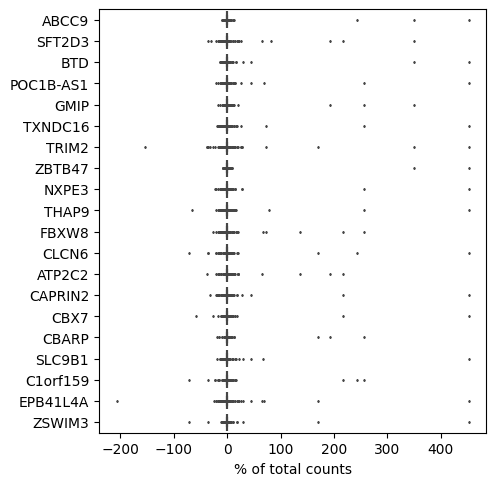

In [84]:
sc.pl.highest_expr_genes(data, n_top=20)

In [117]:
top_1500Genes=sc.pp.highly_variable_genes(data, flavor="seurat", n_top_genes=1500)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


# Dimentionality reduction (PCA)

From the plot, among highest variable gene is ABCC9

In [ ]:
# # Perform PCA
# sc.tl.pca(data)
# # Visualize PCA results
# sc.pl.pca(data, color='leiden')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)


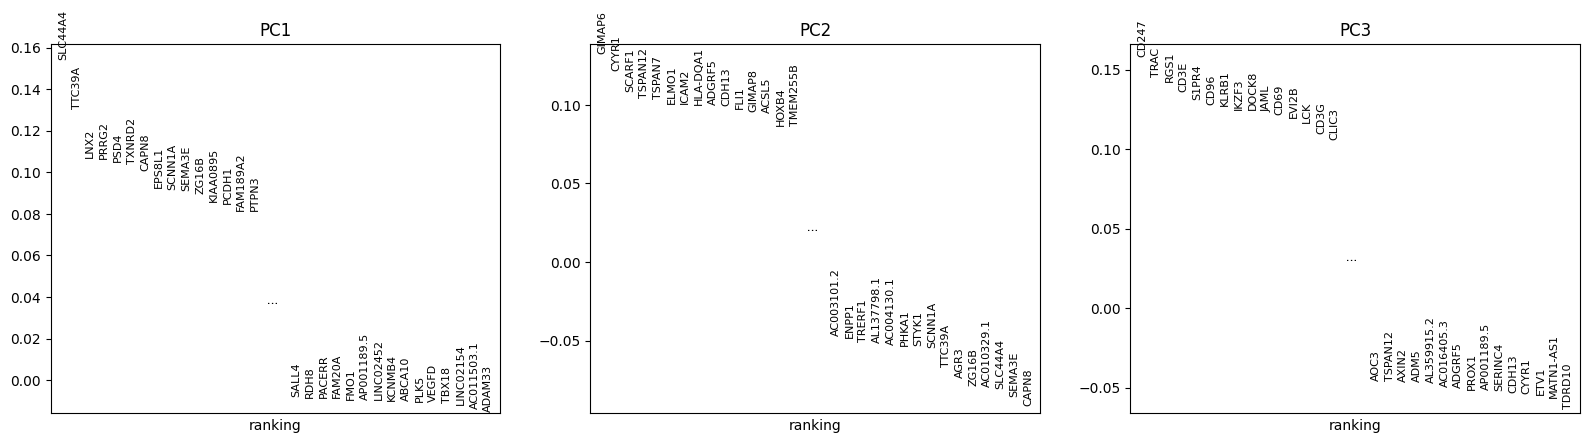

In [88]:
# Perform PCA
sc.tl.pca(data)
# Visualize PCA loadings
sc.pl.pca_loadings(data, show=True)  #

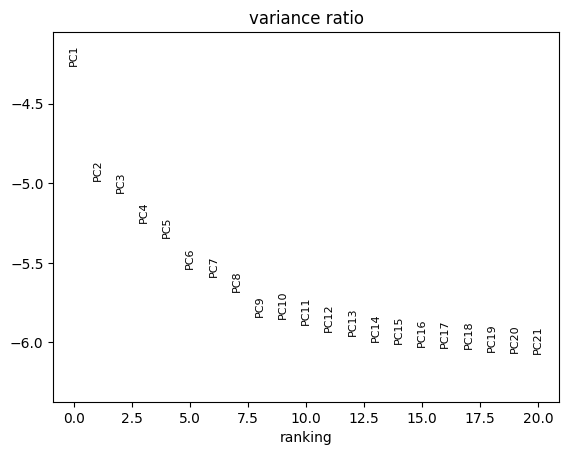

In [89]:
# Visualize PCA variance ratio
sc.pl.pca_variance_ratio(data, n_pcs=20, log=True, show=True)

We will pick number of components to be 9 as this is the optimal PCS from the output of the PCs tested. Only PC1 has positive positive loadings indicating higher expression levels of those genes contribute to higher values of that PC. The remaininng PCs suggest that lower expression levels of those genes contribute to higher values of that PC.

In [121]:
sc.pp.neighbors(data,n_pcs=9)
sc.tl.umap(data)
sc.tl.leiden(data, key_added="clusters")

computing neighbors
    using 'X_pca' with n_pcs = 9
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
running Leiden clustering
    finished: found 20 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:03)


In [122]:
sc.tl.leiden(data)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


# Embedding

computing tSNE
    using 'X_pca' with n_pcs = 9
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:23)


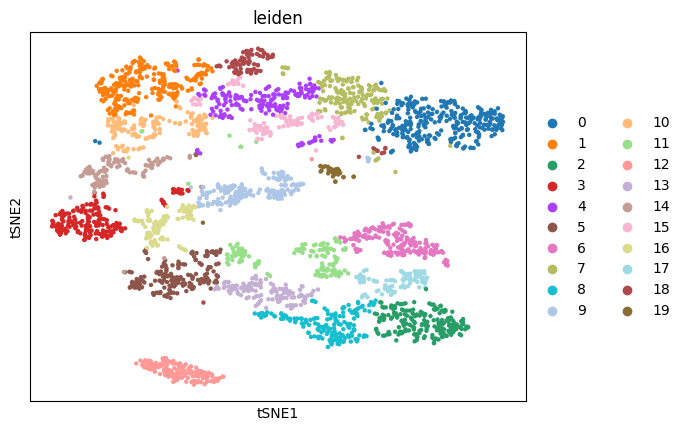

In [124]:
# Embeddings'
# Perform t-SNE
sc.tl.tsne(data,n_pcs=9)
## tSNE
sc.pl.tsne(data, color='leiden')

In [127]:
# # Compute a custom embedding (e.g., UMAP)
# sc.tl.umap(data,n_components=9)
# # Visualize cells in the UMAP space
# sc.pl.embedding(data, basis='umap', color='leiden')

In [378]:
# import numpy as np
# import seaborn as sns
# np.random.seed(42)
# data.obs['condition'] = np.random.choice(['healthy', 'tumor'], size=len(data))

# # Compute UMAP embedding
# sc.tl.umap(data)

# # Visualize the density of cells in the UMAP embedding per condition
# sc.pl.embedding_density(data, basis='umap', key='condition', cmap=sns.color_palette("Set2", as_cmap=True))

# plt.show()

In [126]:
data.obs

n_genes_by_counts  total_counts  total_counts_MT  \
AAACCCAAGTCAGGGT-1               1036        3271.0            227.0   
AAACCCACATCACAGT-1               1720        6521.0             70.0   
AAACCCATCTCAATCT-1               1190        3436.0            299.0   
AAACGAACAAGTTCGT-1               2464        7967.0             91.0   
AAACGAATCTACCCAC-1               2851        9582.0             67.0   
...                               ...           ...              ...   
TTTGGTTGTAGTTCCA-1               2728        6481.0             93.0   
TTTGTTGCAGGCCTGT-1               2973        9842.0            354.0   
TTTGTTGGTAATGATG-1               1143        3268.0             16.0   
TTTGTTGTCCTACAAG-1               4111       14885.0            212.0   
TTTGTTGTCGCTGCGA-1               2454        4830.0            140.0   

                    pct_counts_MT clusters leiden  
AAACCCAAGTCAGGGT-1       6.939774       10     10  
AAACCCACATCACAGT-1       1.073455        4      4  
AAACCCATCTCAATCT-1       8.701980        9      9  
AAACGAACAAGTTCGT-1       1.142212       17     17  
AAACGAATCTACCCAC-1       0.699228        7      7  
...                           ...      ...    ...  
TTTGGTTGTAGTTCCA-1       1.434964        6      6  
TTTGTTGCAGGCCTGT-1       3.596830        8      8  
TTTGTTGGTAATGATG-1       0.489596       10     10  
TTTGTTGTCCTACAAG-1       1.424253        0      0  
TTTGTTGTCGCTGCGA-1       2.898551       19     19  

[2972 rows x 6 columns]

## Clustering of highly variable genes
Leiden algorithm was be used for hierarchical clustering, allowing for to discover and characterize cell types or states within a heterogeneous sample.

In [417]:
# Extracting top 1500 genes
top_1500Genes=sc.pp.highly_variable_genes(data, flavor="seurat", n_top_genes=1500)
top_1500Genes

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)


## UMAP clustering
UMAP was used as an effective preprocessing step to boost the performance of density based clustering.
## steps
- Obtain highly variable genes
- Rank the genes in order of counts
- Cluster the genes into distinct groups
- Rank the genes in each cluster


In [135]:
sc.pp.neighbors(data,n_pcs=9)
sc.tl.umap(data,n_components=9)
sc.tl.leiden(data, key_added="clusters")

computing neighbors
    using 'X_pca' with n_pcs = 9
    finished (0:00:00)
computing UMAP
    finished (0:00:17)
running Leiden clustering
    finished (0:00:03)


In [137]:
sc.tl.leiden(data)

running Leiden clustering
    finished (0:00:03)


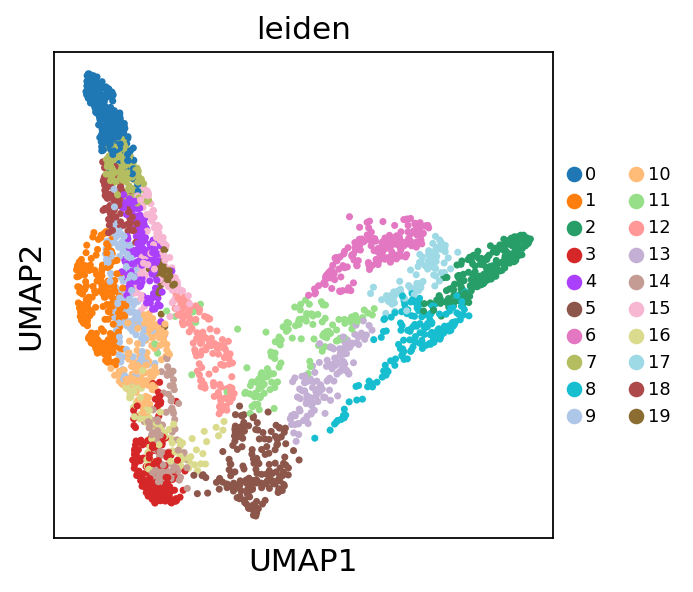

In [138]:
sc.pl.umap(data, color=['leiden'], legend_fontsize=8, save='_leiden')

In [139]:

import scanpy as sc
import pandas as pd
from matplotlib import rcParams
sc.tl.rank_genes_groups(data, 'leiden', method='t-test')
# The head function returns the top n genes per cluster
top_markers = pd.DataFrame(data.uns['rank_genes_groups']['names']).head(5)
print(top_markers)

ranking genes
    finished (0:00:02)
       0        1       2       3       4         5      6        7        8  \
0  PRRX1  GADD45B   CLDN7   PLCG2    CTSL     PLCG2  KRT17     CTSL     AREG   
1  GSTO1    PNRC1  SPINT2  MALAT1     GEM    MALAT1   TPM1  TNFAIP6    KRT18   
2   CTSL    NR4A1   KRT18    SELE    CNBP  ANKRD30A  KRT14    GSTO1     KRT8   
3  MEDAG    ZFP36   GOLM1  C2CD4B    TOP1      AREG    SFN   SERBP1     ELF3   
4    PKM    CCNL1   ANXA3  ANGPT2  HNRNPC      TCIM   KRT7     NIFK  DNAJC12   

        9      10     11      12      13       14       15       16        17  \
0  TM4SF1     DCN   KRT7   CXCR4  MYL12B   MALAT1    ANXA5  SPARCL1  PPP1R14B   
1   IFI27     GEM   SAA1   HLA-C    AREG  GADD45B      GEM    RPS18     CLDN7   
2  IGFBP7  RPL35A   RPS2     B2M    SAT1    NR4A1   CHCHD2    RPL30     KRT18   
3   HLA-B     VIM  KRT17  TMSB4X  S100A6      FOS  TNFAIP6    RPS12     EPCAM   
4     ID3   RPL12   TPM1    CYBA  MYL12A     APOD     CTSL   TMSB4X    SPINT2

The UMAP clustering shows 11 distinct cell categories. In the next steps, we are going to unpack each category to determine which genes are differentially expressed in the cell categories.

# Top Marker genes  per category
The top gene per category of cells have been extracted for spatial analysis i.e to get the patterns of tgeir distribution in other cells. From the results of the marker gene extraction after log nomalization and quakity control, CTSL gene is the most variable gene across the cell types.

In [153]:
top_genes_list = []

# Iterate over the columns (categories) of the DataFrame
for col in top_markers.columns:
    # Extract the top genes for the current category and convert them to a list
    top_genes_sublist = top_markers[col].tolist()[0]
    
    # Append the sublist of top genes to the main list
    top_genes_list.append(top_genes_sublist)

# Print the list of lists
print(top_genes_list)

['PRRX1', 'GADD45B', 'CLDN7', 'PLCG2', 'CTSL', 'PLCG2', 'KRT17', 'CTSL', 'AREG', 'TM4SF1', 'DCN', 'KRT7', 'CXCR4', 'MYL12B', 'MALAT1', 'ANXA5', 'SPARCL1', 'PPP1R14B', 'TNFAIP6', 'SRGN']


In [158]:
marker_genes = list(set(top_genes_list))

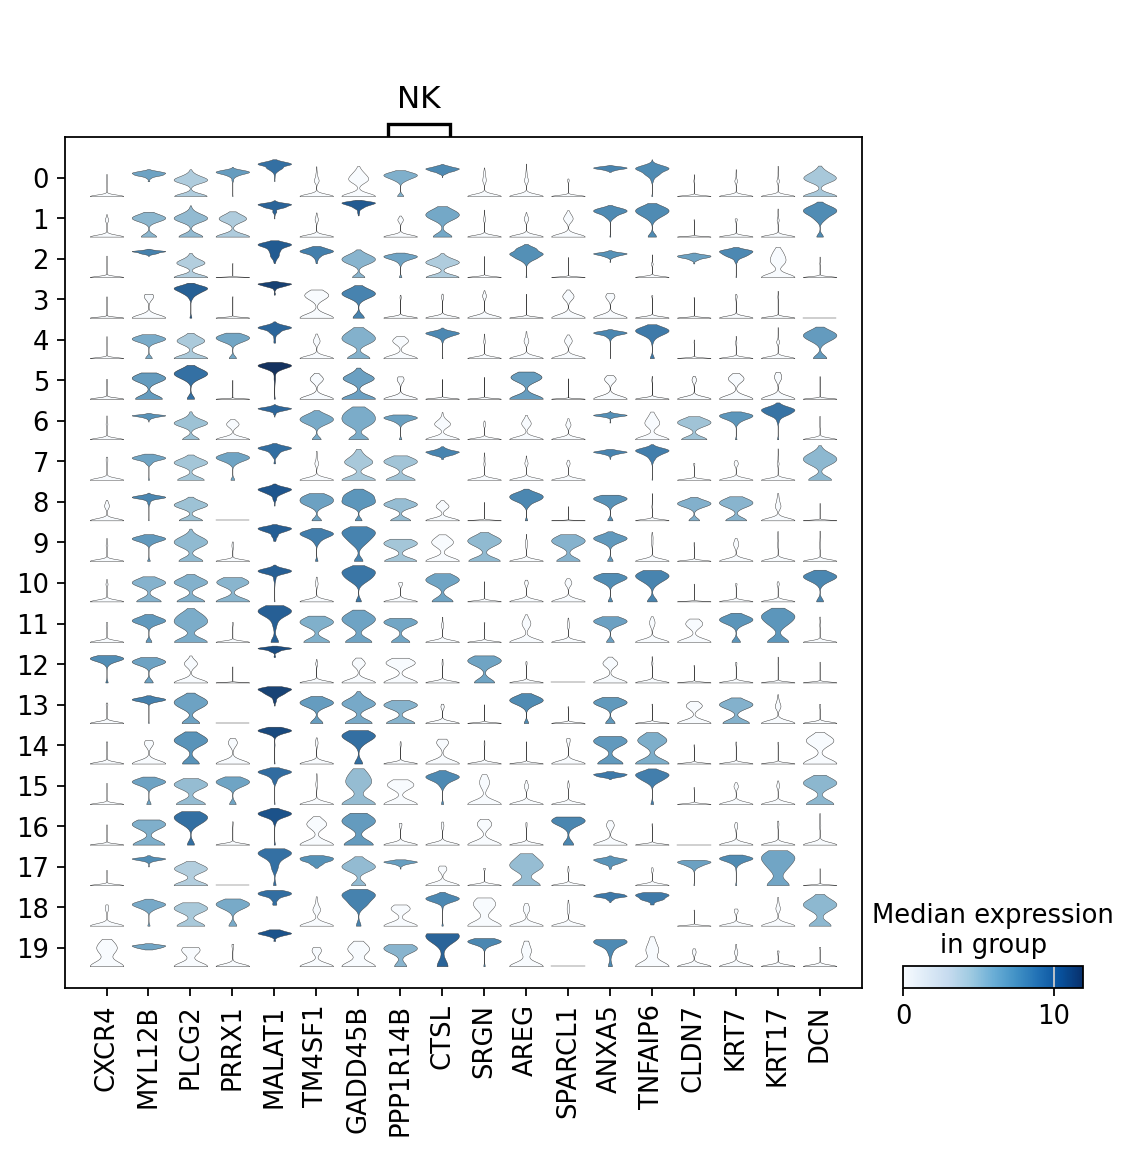

In [159]:
# Marker genes per cluster
ax = sc.pl.stacked_violin(data, marker_genes, groupby='leiden',
                         var_group_positions=[(7, 8)], var_group_labels=['NK'])

We can see that genes such as C2CD4B are unqiuely differentially expressed in specific categories while genes such as CTSL are expressed in more than one type of cells in clusters 10,5,1 and 0. We can visualize the gene clustering using a dot plot with a dendrogram
to show the relatedness and level of the gene expression across different cells as shown below. Track plot also shows the gene expression profiles using baar graphs as shown below.

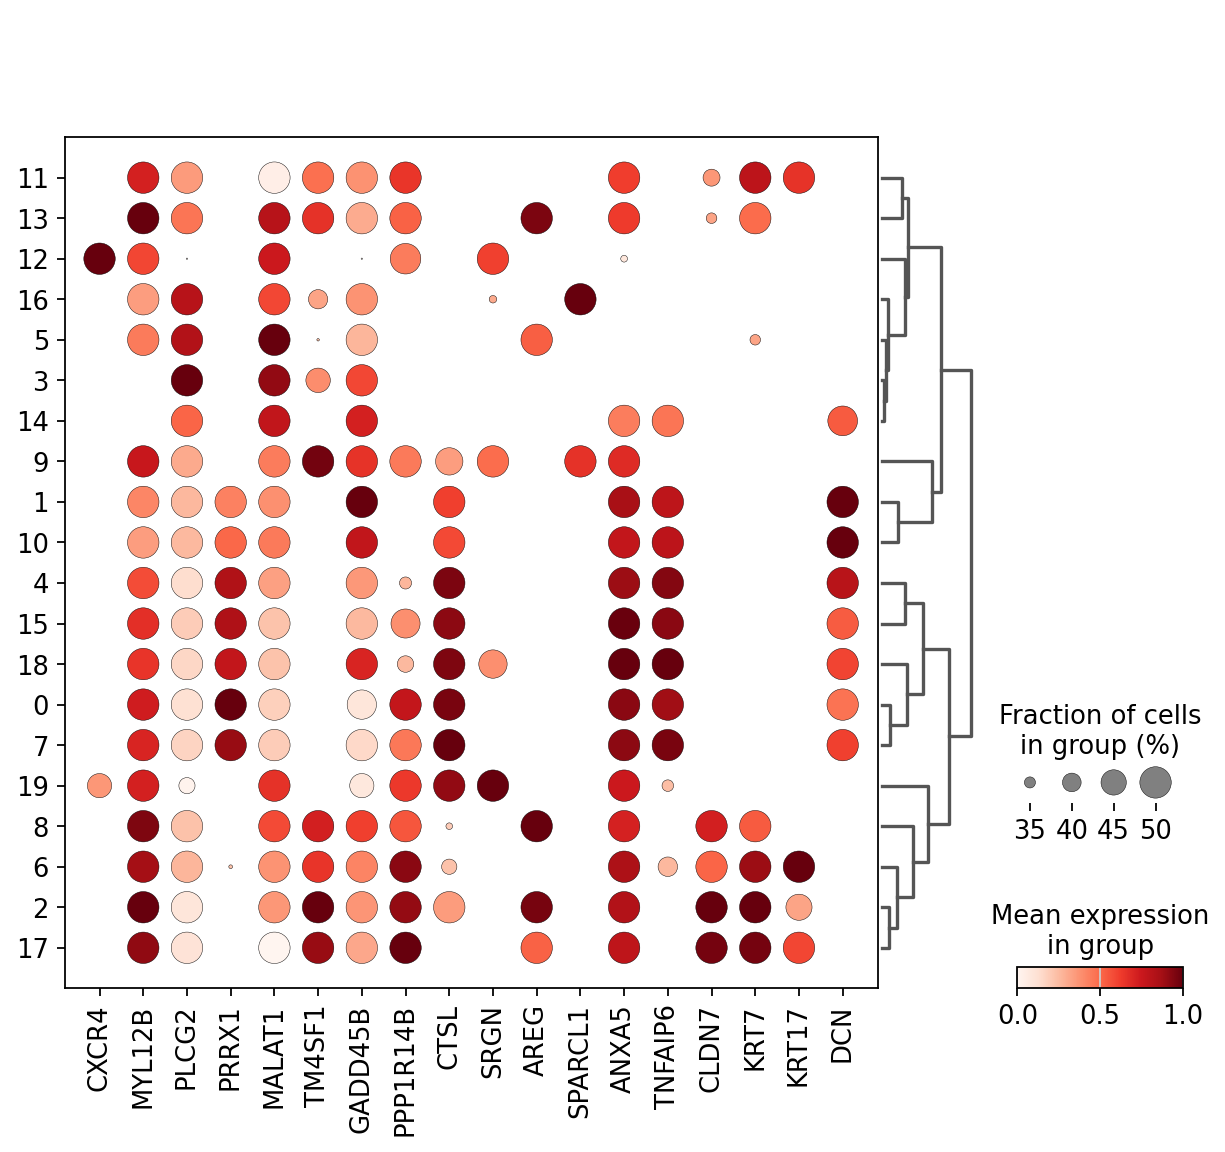

In [160]:
ax = sc.pl.dotplot(data, marker_genes, groupby='leiden', dendrogram=True, dot_max=0.5, dot_min=0.3, standard_scale='var')

From the dot plot and using the top selected genes per cluster, expression patterns in clusters 8 and 9 are closer than other expression patterns. Also, classes 2 and 10 are closely related in their expression patterns.  Among the cell types, CTSL is the highest expressed in all the six cell types. AREG gene is highly expressed in two cell types for clusters 9 and 5. The output also suggests co-expression patterns for KRT8 and KRT18. This is evident by the fact that clusters that show differential expression for the AREG gene also have differential expression of the KRT18 gene. Some genes are also shown to be interrelated and may be involved in similar metabolic pathways. For example. In cluster 11, CTSL, SRGN, and HLA-DQA1 are highly expressed and their overexpressed seems to cause the underexpression of AREG, TNFA1P6, and CXCR4. 

We can also see the CD8 to be one of the high

# Cell types based on marker genes

We can use the marker gene to identify the cell types. These marker genes were obtained from the literature.

categories: 0, 1, 2, etc.
var_group_labels: B-cell, T-cell, T-cell CD8+, etc.


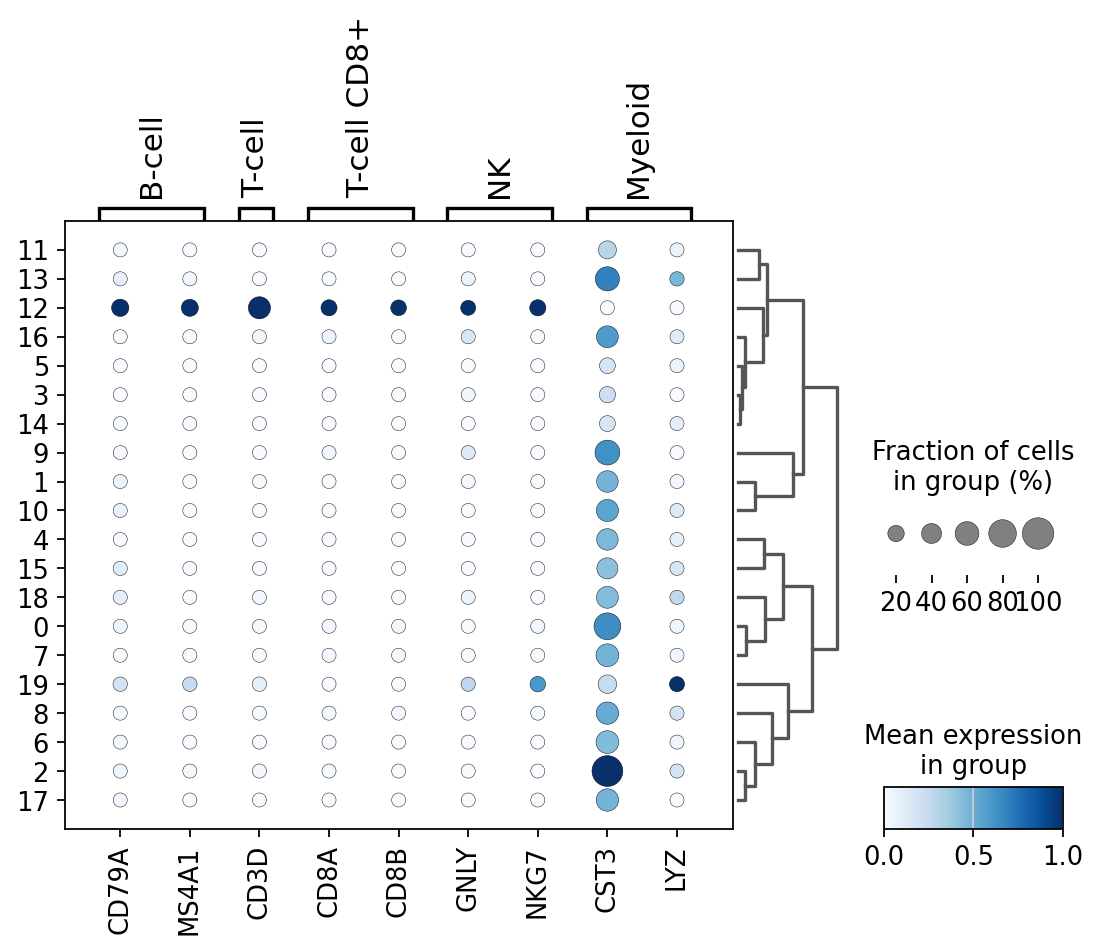

In [161]:

marker_genes_dict = {'B-cell': ['CD79A', 'MS4A1'],
                     'T-cell': 'CD3D',
                     'T-cell CD8+': ['CD8A', 'CD8B'],
                     'NK': ['GNLY', 'NKG7'],
                     'Myeloid': ['CST3', 'LYZ'],
                     # 'Monocytes': ['FCGR3A'],
                     # 'Dendritic': ['FCER1A']
                    }


ax = sc.pl.dotplot(data, marker_genes_dict, groupby='leiden', dendrogram=True,
                   standard_scale='var', smallest_dot=40, color_map='Blues', figsize=(8,5))

# Track plots
Track plots is another way of visualizing expression patterns of genes per cell type

In [163]:
# Track plot data is better visualized using the non-log counts
import numpy as np
ad = data.copy()
ad.raw.X.data = np.exp(ad.raw.X.data)

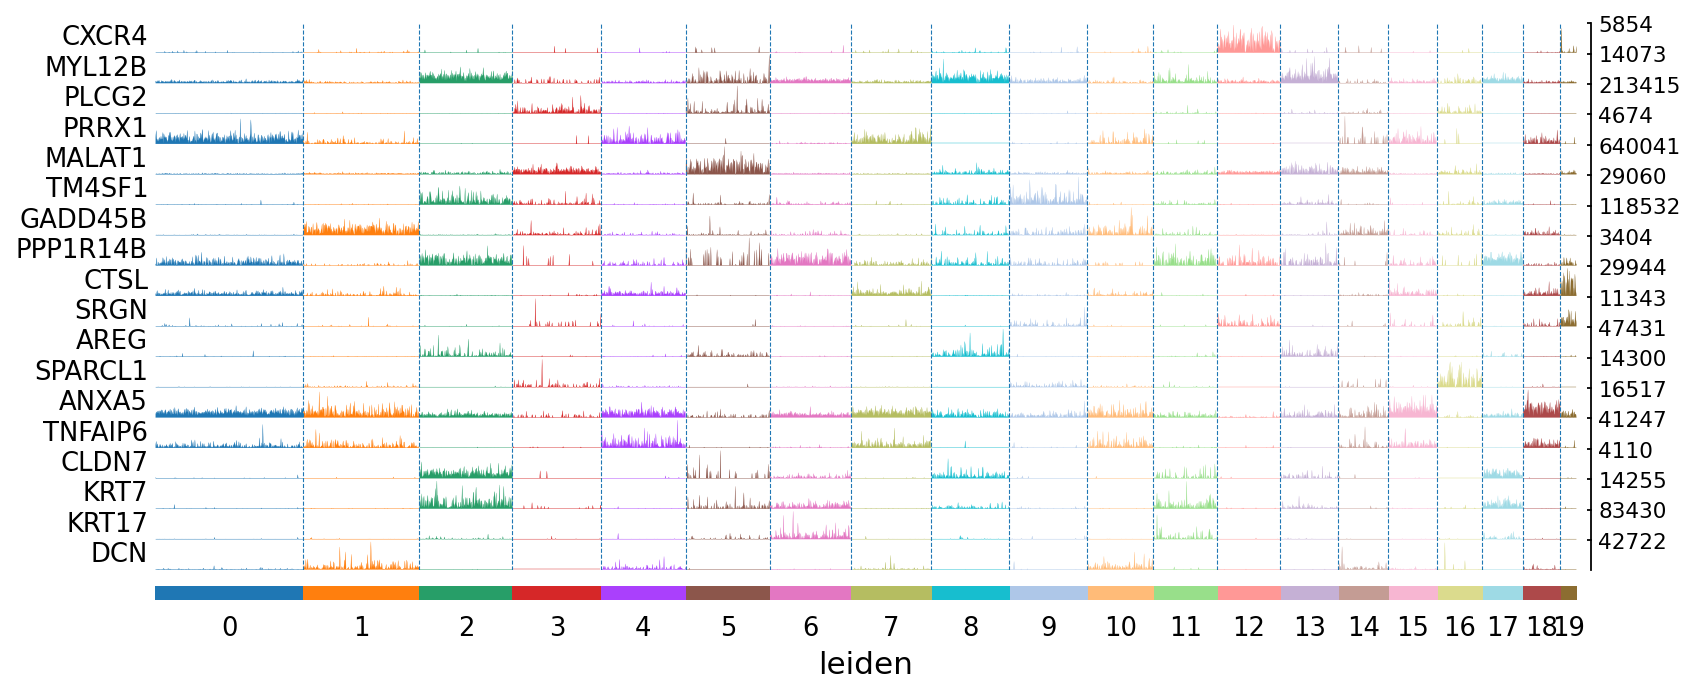

In [164]:
ax = sc.pl.tracksplot(ad,marker_genes, groupby='leiden')

# We can see similar expression patterns in clusster 2  and 3 

# Marker gene Visualization

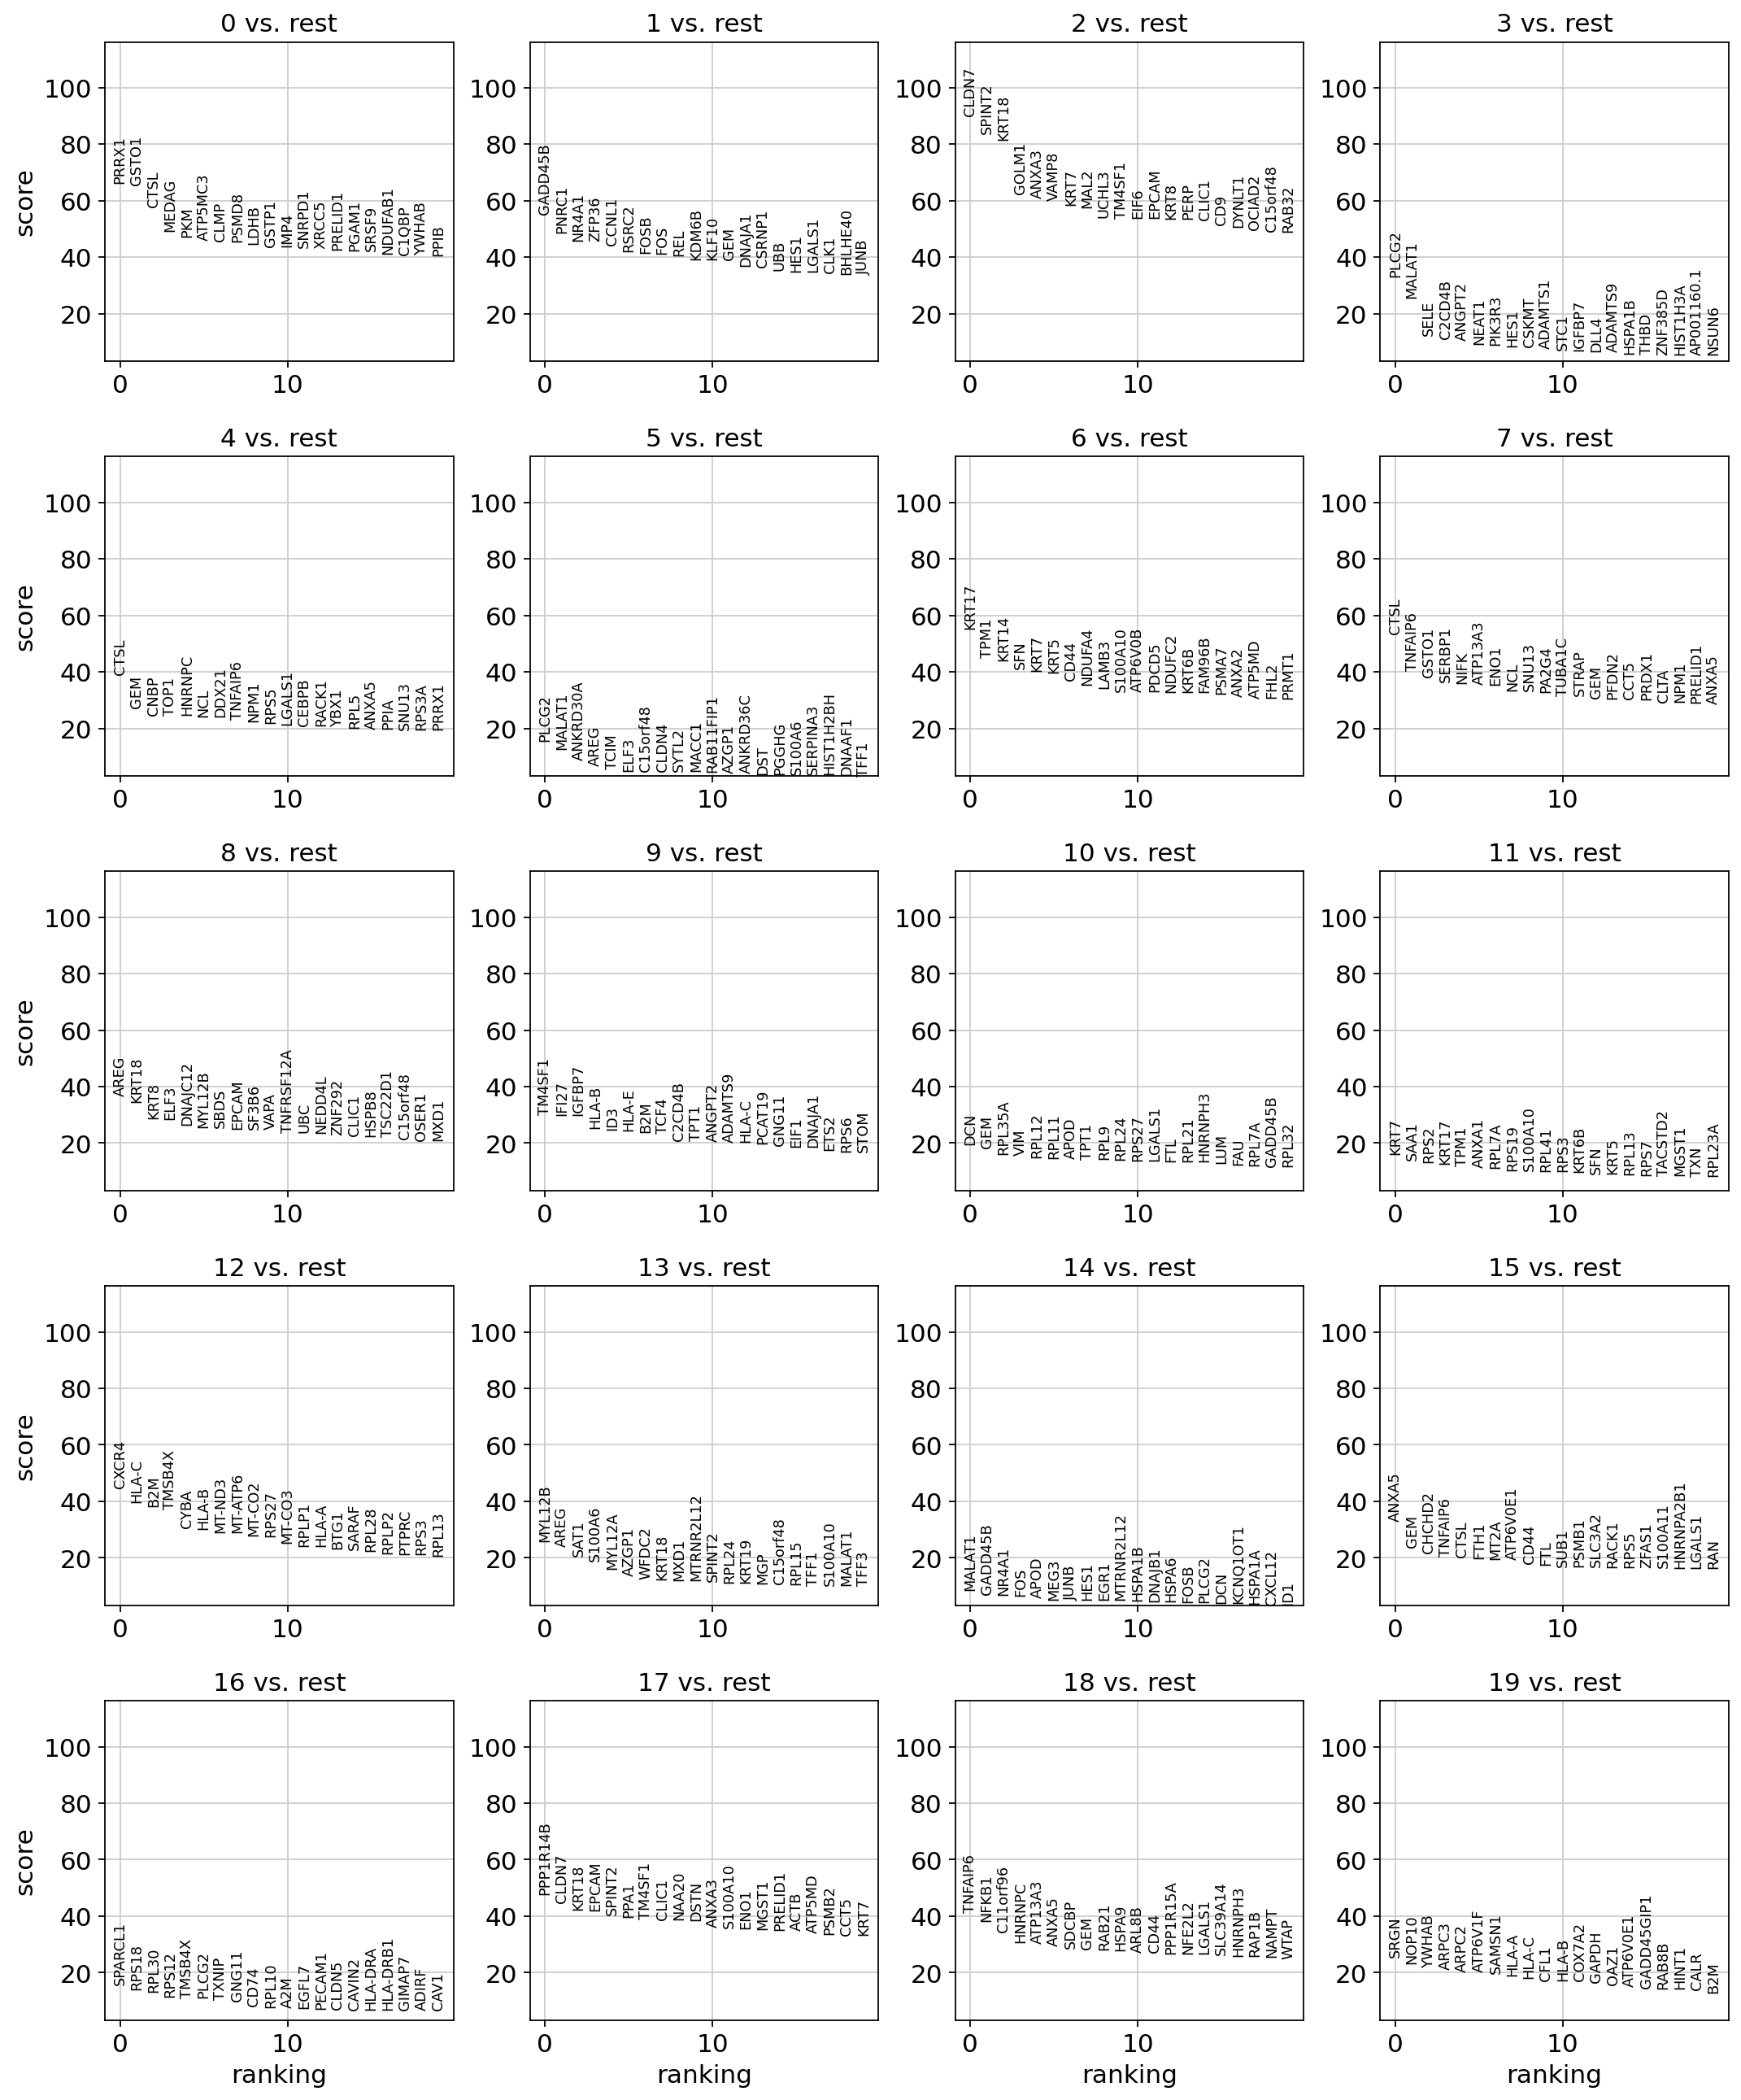

In [165]:
#v one vs rest visualization
rcParams['figure.figsize'] = 4,4
rcParams['axes.grid'] = True
sc.pl.rank_genes_groups(data)

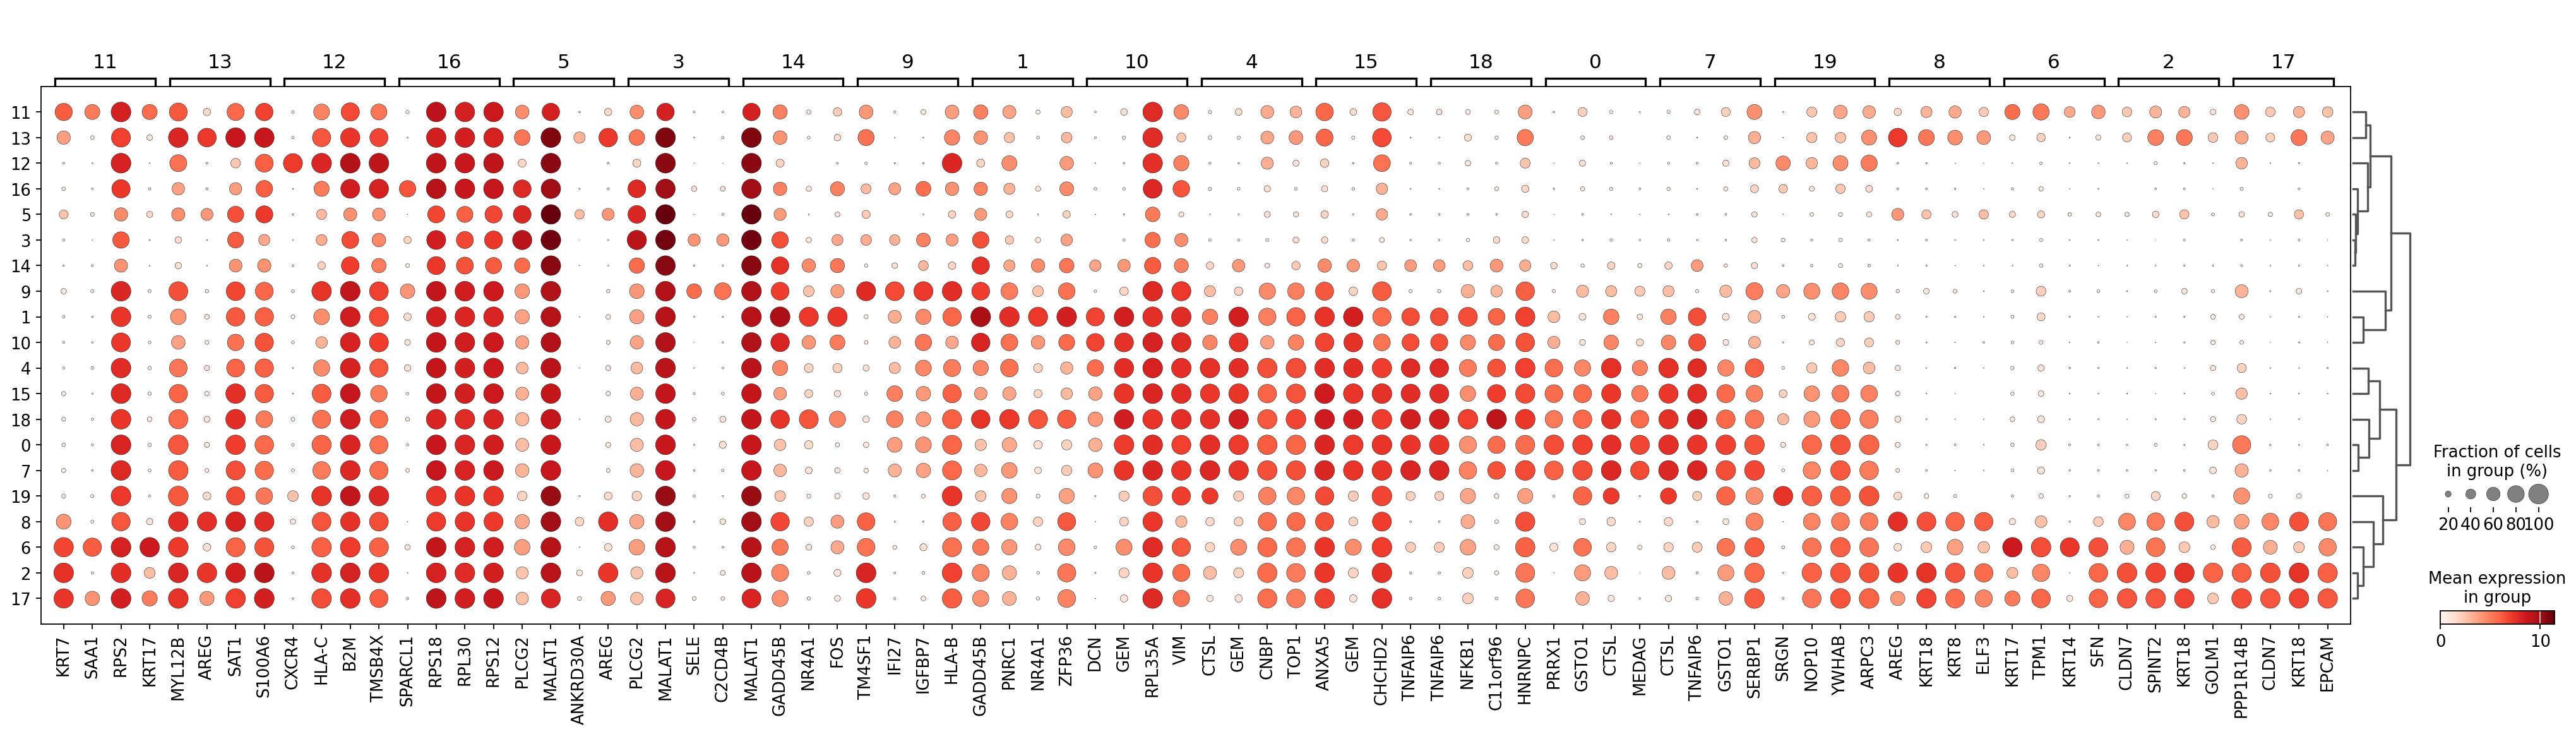

In [166]:
sc.pl.rank_genes_groups_dotplot(data, n_genes=4)

# Heat Map for differentially exprssed genes per  cell type category

ranking genes
    finished (0:00:02)
categories: 0, 1, 2, etc.
var_group_labels: 5


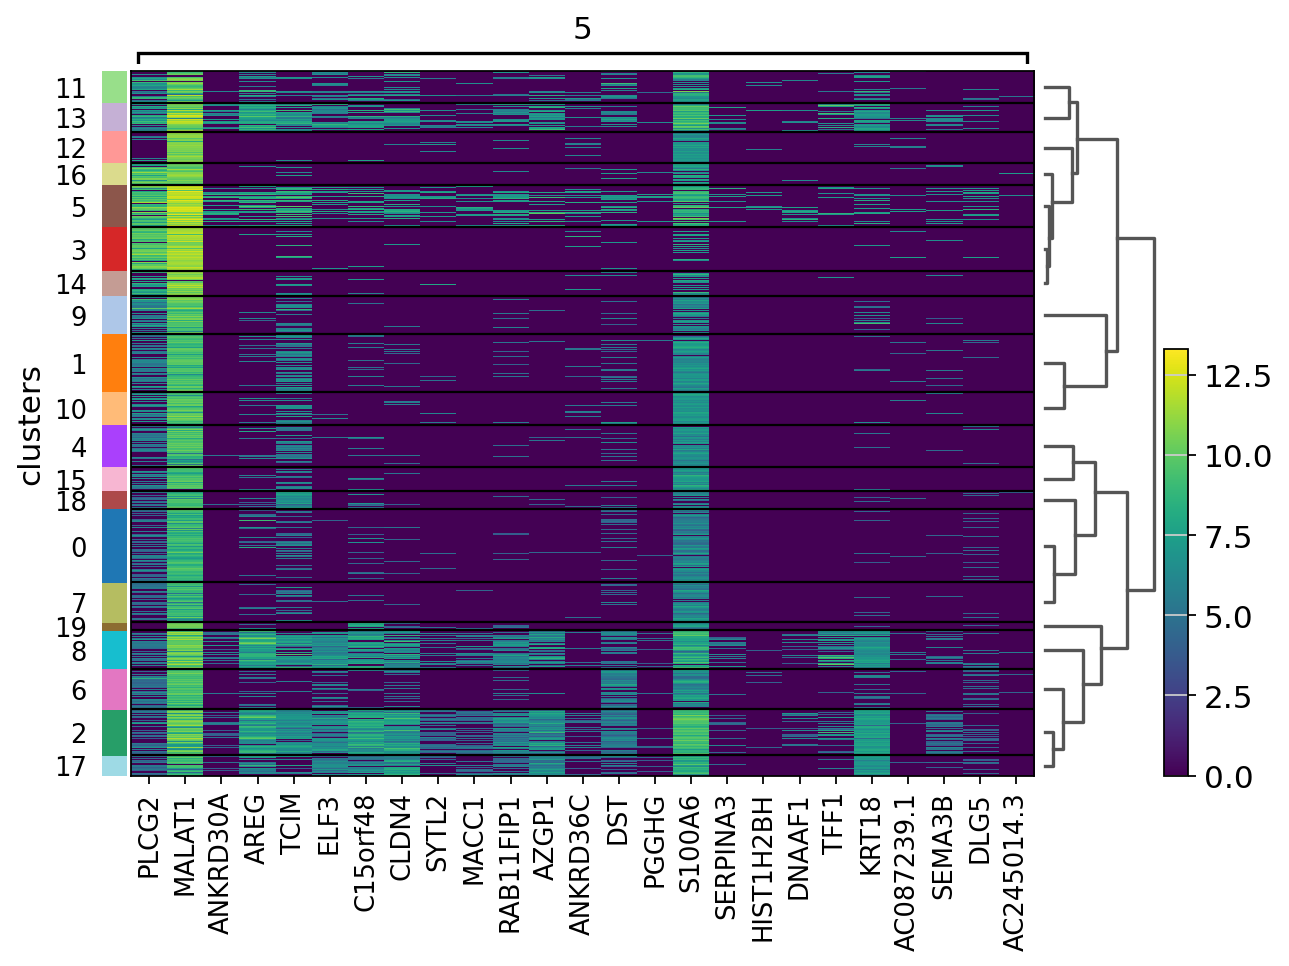

In [167]:
sc.tl.rank_genes_groups(data, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(data, groups="5", n_genes=25, groupby="clusters")

# Pathway Analysis


In [168]:
sc.queries.enrich({'set1':['KLF4', 'PAX5'], 'set2':['SOX2', 'NANOG']}, org="hsapiens")

source                native  \
0    REAC    REAC:R-HSA-2892245   
1   GO:BP            GO:0001714   
2   GO:BP            GO:0001711   
3    REAC    REAC:R-HSA-2892247   
4    REAC    REAC:R-HSA-9754189   
5    REAC     REAC:R-HSA-452723   
6   GO:BP            GO:0060795   
7      WP             WP:WP2406   
8      WP             WP:WP3527   
9   GO:BP            GO:0035987   
10  GO:BP            GO:0001706   
11   REAC    REAC:R-HSA-9758941   
12  GO:BP            GO:0035019   
13     WP              WP:WP399   
14     WP             WP:WP5322   
15   KEGG            KEGG:04550   
16  GO:BP            GO:0007492   
17     WP             WP:WP2853   
18     WP             WP:WP2857   
19     WP              WP:WP706   
20  GO:BP            GO:0001708   
21  GO:BP            GO:0001704   
22   REAC    REAC:R-HSA-6785807   
23  GO:BP            GO:0019827   
24  GO:BP            GO:0098727   
25  MIRNA  MIRNA:hsa-miR-34c-5p   
26  GO:BP            GO:0007369   
27  GO:BP            GO:1904998   
28  GO:MF            GO:0001010   
29  CORUM            CORUM:2802   
30  CORUM            CORUM:2803   

                                                 name   p_value  significant  \
0   POU5F1 (OCT4), SOX2, NANOG repress genes relat...  0.000014         True   
1                  endodermal cell fate specification  0.000066         True   
2                     endodermal cell fate commitment  0.000248         True   
3   POU5F1 (OCT4), SOX2, NANOG activate genes rela...  0.000304         True   
4                Germ layer formation at gastrulation  0.000626         True   
5   Transcriptional regulation of pluripotent stem...  0.001064         True   
6   cell fate commitment involved in formation of ...  0.001171         True   
7                  Cardiac progenitor differentiation  0.001597         True   
8                             Pre-implantation embryo  0.001983         True   
9                     endodermal cell differentiation  0.002775         True   
10                                 endoderm formation  0.003901         True   
11                                       Gastrulation  0.004978         True   
12           somatic stem cell population maintenance  0.005218         True   
13             Wnt signaling pathway and pluripotency  0.005737         True   
14                        CKAP4 signaling pathway map  0.007730         True   
15  Signaling pathways regulating pluripotency of ...  0.007779         True   
16                               endoderm development  0.008425         True   
17                           Endoderm differentiation  0.011767         True   
18                      Mesodermal commitment pathway  0.013300         True   
19  Sudden infant death syndrome (SIDS) susceptibi...  0.014558         True   
20                            cell fate specification  0.014934         True   
21                    formation of primary germ layer  0.018584         True   
22         Interleukin-4 and Interleukin-13 signaling  0.027606         True   
23                   stem cell population maintenance  0.038018         True   
24                         maintenance of cell number  0.039732         True   
25                                     hsa-miR-34c-5p  0.043106         True   
26                                       gastrulation  0.043725         True   
27  negative regulation of leukocyte adhesion to a...  0.049580         True   
28  RNA polymerase II sequence-specific DNA-bindin...  0.049655         True   
29                      OCT1-SOX2 DNA-protein complex  0.049932         True   
30                      PAX6-SOX2 DNA-protein complex  0.049932         True   

                                          description  term_size  query_size  \
0   POU5F1 (OCT4), SOX2, NANOG repress genes relat...          3           2   
1   "The cell fate determination process that resu...          8           2   
2   "The cell differentiation process that results...         15           2   
3

# Results and Discussion
- Cathepsin L (CTSL), is a lysosomal acid cysteine protease that has been reported to play a critical role in chemosensitivity and tumor progression. I has been found that CTSL served as a prognostic marker for poor clinical outcomes in Neuroblastoma patients [4] and breat cancer [5].
-  AREG has ben suggested as a valuable prognostic biomarker in invasive breast cancer and promising therapeutic targets, especially in ER-negative breast cancer [6]
- The study suggests co-expresion patterns of KRT8 and KRT 18 genes 8, 5 and 9. Previous studies have shown the co-expression of these genes in cancer breat patients [7].
- The expression of the HLA-DQA1 significantly upregulated in breast cancer a sin line with the previous findings [8].
-  IGFBP7 was reported to play tumor suppressive role in breast cancer[9]

# Conclusion
- This project has shown the co-expression pattersn for KRT8 and KRT 18 genes genes
- Most cancer associated genes are CTSL,AREG  and DCN

# References
https://tcr.amegroups.org/article/view/76142/html

1. Kim H, Whitman AA, Wisniewska K, Kakati RT, Garcia-Recio S, Calhoun BC, Franco HL, Perou CM, Spanheimer PM. Tamoxifen Response at Single Cell Resolution in Estrogen Receptor-Positive Primary Human Breast Tumors. bioRxiv [Preprint]. 2023 Apr 19:2023.04.01.535159. doi: 10.1101/2023.04.01.535159. Update in: Clin Cancer Res. 2023 Sep 25;: PMID: 37066379; PMCID: PMC10103953.
2. Wei Z, Shen Y, Zhou C, Cao Y, Deng H, Shen Z. CD3D: a prognostic biomarker associated with immune infiltration and immunotherapeutic response in head and neck squamous cell carcinoma. Bioengineered. 2022 May;13(5):13784-13800. doi: 10.1080/21655979.2022.2084254. PMID: 35712757; PMCID: PMC9276048.
3. Lu, J., Ahmad, R., Nguyen, T. et al. Heterogeneity and transcriptome changes of human CD8+ T cells across nine decades of life. Nat Commun 13, 5128 (2022). https://doi.org/10.1038/s41467-022-32869-x
4. Du, X., Ding, L., Huang, S., Li, F., Yan, Y., Tang, R., ... & Wang, W. (2022). Cathepsin L promotes chemresistance to neuroblastoma by modulating serglycin. Frontiers in Pharmacology, 13, 920022.
5. Zhang, L., Zhao, Y., Yang, J., Zhu, Y., Li, T., Liu, X., ... & Fu, J. (2023). CTSL, a prognostic marker of breast cancer, that promotes proliferation, migration, and invasion in cells in triple-negative breast cancer. Frontiers in Oncology, 13, 1158087.
6. Xiang, G., Liu, F., Liu, J., Meng, Q., Li, N., & Niu, Y. (2019). Prognostic role of Amphiregulin and the correlation with androgen receptor in invasive breast cancer. Pathology-Research and Practice, 215(6), 152414.
7. Wilson, C. A., & Dering, J. (2004). Recent translational research: microarray expression profiling of breast cancer–beyond classification and prognostic markers?. Breast Cancer Research, 6, 1-9.
8. Wu, G., Xiao, G., Yan, Y., Guo, C., Hu, N., & Shen, S. (2022). Bioinformatics analysis of the clinical significance of HLA class II in breast cancer. Medicine, 101(40).
9. Li, D., Xia, L., Huang, P., Wang, Z., Guo, Q., Huang, C., ... & Qin, S. (2023). Cancer-associated fibroblast-secreted IGFBP7 promotes gastric cancer by enhancing tumor associated macrophage infiltration via FGF2/FGFR1/PI3K/AKT axis. Cell Death Discovery, 9(1), 17.
10. https://www.sc-best-practices.org/introduction/analysis_tools.html